Train Epoch: 1 	 Loss: 2.301505
Epoch 1 time: 18.78 seconds
Test -- Average loss: 0.0007, Accuracy: 98.600

Train Epoch: 2 	 Loss: 0.072409
Epoch 2 time: 19.17 seconds
Test -- Average loss: 0.0006, Accuracy: 98.730

Train Epoch: 3 	 Loss: 0.023574
Epoch 3 time: 18.58 seconds
Test -- Average loss: 0.0006, Accuracy: 98.730

Train Epoch: 4 	 Loss: 0.029821
Epoch 4 time: 19.15 seconds
Test -- Average loss: 0.0006, Accuracy: 98.790

Train Epoch: 5 	 Loss: 0.061575
Epoch 5 time: 17.77 seconds
Test -- Average loss: 0.0005, Accuracy: 98.940

Train Epoch: 6 	 Loss: 0.000245
Epoch 6 time: 17.83 seconds
Test -- Average loss: 0.0005, Accuracy: 99.090

Train Epoch: 7 	 Loss: 0.000922
Epoch 7 time: 17.68 seconds
Test -- Average loss: 0.0006, Accuracy: 98.930

Train Epoch: 8 	 Loss: 0.044371
Epoch 8 time: 17.54 seconds
Test -- Average loss: 0.0008, Accuracy: 98.910

Train Epoch: 9 	 Loss: 0.000014
Epoch 9 time: 17.84 seconds
Test -- Average loss: 0.0007, Accuracy: 98.870

Train Epoch: 10 	 Loss: 0.14

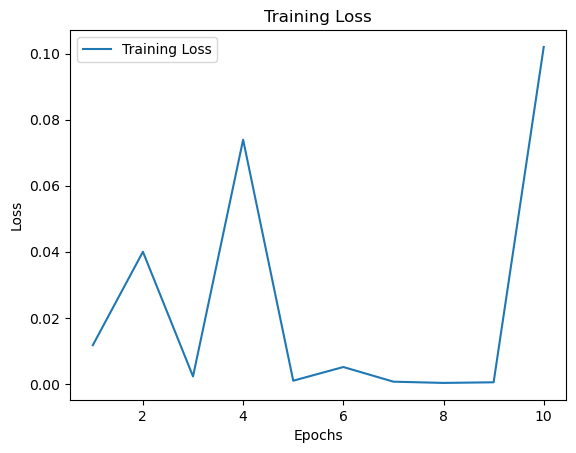

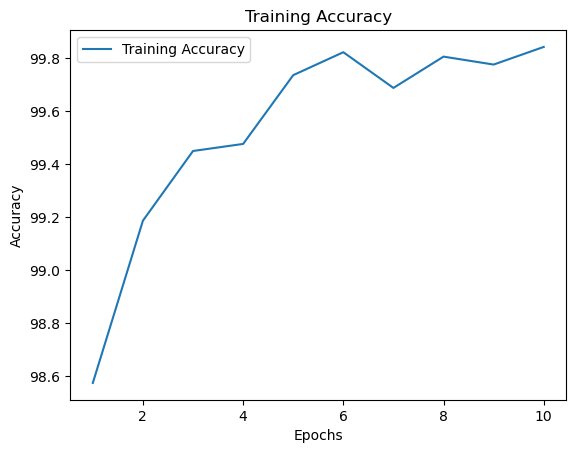

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# 超参数
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10

# 图像处理
pipeline = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# 下载加载数据集
train_set = datasets.MNIST("data", train=True, download=True, transform=pipeline)
test_set = datasets.MNIST("data", train=False, download=True, transform=pipeline)

# 加载数据
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)


# 构建网络模型
class Digit(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.fc1 = nn.Linear(20 * 10 * 10, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        input_size = x.size(0)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = self.conv2(x)
        x = F.relu(x)

        x = x.view(input_size, -1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)

        return output


# 优化器
model = Digit().to(DEVICE)
optimizer = optim.Adam(model.parameters())


# 训练方法
def train_model(model, device, train_loader, optimizer, epoch):
    model.train()
    train_losses = []
    train_accuracy = []
    start_time = time.time()
    for batch_index, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_index % 1000 == 0:
            print("Train Epoch: {} \t Loss: {:.6f}".format(epoch, loss.item()))

    # 计算准确率
    model.eval()
    correct = 0.0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100.0 * correct / len(train_loader.dataset)
    train_accuracy.append(accuracy)

    train_losses.append(loss.item())
    end_time = time.time()
    epoch_time = end_time - start_time

    return train_losses, train_accuracy, epoch_time


# 测试方法
def test_model(model, device, test_loader):
    model.eval()
    correct = 0.0
    test_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(
        "Test -- Average loss: {:.4f}, Accuracy: {:.3f}\n".format(
            test_loss, 100.0 * correct / len(test_loader.dataset)
        )
    )


# 调用
train_losses = []
train_accuracy = []
total_time = 0.0
for epoch in range(1, EPOCHS + 1):
    losses, accuracy, epoch_time = train_model(model, DEVICE, train_loader, optimizer, epoch)
    train_losses.extend(losses)
    train_accuracy.extend(accuracy)
    total_time += epoch_time
    print("Epoch {} time: {:.2f} seconds".format(epoch, epoch_time))
    test_model(model, DEVICE, test_loader)

print("Total training time: {:.2f} seconds".format(total_time))

# 绘制损失曲线
plt.plot(range(1, EPOCHS + 1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# 绘制准确率曲线
plt.plot(range(1, EPOCHS + 1), train_accuracy, label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.show()
